# Calibration code

In [78]:
import numpy         as np
import pandas        as pd 
import os 
import math 
from   collections   import defaultdict
import matplotlib.pyplot as plt 
from george.kernels  import Matern32Kernel
from scipy           import optimize   as op
import george
from astropy.io     import ascii 
from joblib          import Parallel, delayed
import shutil
from multiprocessing import Pool

In [79]:
lc_path       = "/home/andrea/Desktop/CASTOR2.0/Training_Set/data_lightcurves/"
sp_path       = "/home/andrea/Desktop/CASTOR2.0/Training_Set/data_spectra/"
training_path = "/home/andrea/Desktop/CASTOR2.0/Training_Set/"

In [80]:
light_vel_A  = 3e+18         #A/s

In [81]:
training_set  = pd.read_excel(training_path + 'Training_Set.xlsx' )['Name'].tolist()

In [82]:
bandpass               = {}

filterlist  = ['u', 'g', 'r', 'i', 'z', 'y', 
	           'U', 'B', 'V', 'R', 'I', 'Y',
	           'w2', 'm2', 'w1', 
	           'J', 'H', 'K']

bandpass = { 'u': (3546, 457), 'g': (4767, 928), 'r': (6156, 813), 'i': (7472, 891), 'z': (8917, 1183), 'y': (10100, 600), 
	     'U': (3571, 524), 'B': (4344, 797), 'V': (5456, 807), 'R': (6442, 1377), 'I': (7994, 1079), 'Y': (10380, 2130), 
	     'w2': (1928, 657), 'm2': (2246, 498), 'w1': (2600, 693),
	     'J':(12500, 3110), 'H':(16300, 4020), 'K':(21900, 3930)
	     }

In [83]:
def sampling_step(x):
    dx = np.diff(np.sort(x))
    return dx[dx != 0]

def nll(p, y, gp, computed):
  gp.set_parameter_vector(p)
  ll = gp.log_likelihood(y, quiet=True)
  return -ll if np.isfinite(ll) else 1e25

def grad_nll(p, y, gp, computed):
  gp.set_parameter_vector(p)
  return -gp.grad_log_likelihood(y, quiet=True)

In [84]:
def collect_lightcurves(name, path):
    lc_path   = path +  name + ".dat"
    lc_set    = defaultdict(list)
    band_dict = defaultdict(list)

    with open(lc_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            time  = float(parts[0])
            mag   = float(parts[1])
            emag  = float(parts[2])
            band  = parts[3]

            band_dict[band].append((time, mag, emag))

    for band, values in band_dict.items():
        lc_set[f'time_{band}'], lc_set[f'mag_{band}'], lc_set[f'emag_{band}'] = zip(*values)

    lc_filters         = list(band_dict.keys())
    ordered_lc_filters = [band for band in filterlist if band in lc_filters]

    return ordered_lc_filters, lc_set


def process_filter(filtro, ref_new_set, ref_time):

    x         = np.array(ref_new_set['time_' + filtro])
    y         = np.array(ref_new_set['mag_' + filtro])
    yerr      = np.array(ref_new_set['emag_' + filtro])
    amplitude = np.mean(y)

    lengthscale0 = np.mean(x)
    lengthscale1 = np.min(sampling_step(x))
    lengthscale2 = np.max(sampling_step(x))


    k0           = amplitude * Matern32Kernel(lengthscale0)
    k1           = amplitude * Matern32Kernel(lengthscale1)
    k2           = amplitude * Matern32Kernel(lengthscale2)
    kernel       = k1 + k2 + k0 

    gp           = george.GP(kernel)
    star         = gp.compute(x, yerr)

    p0           = gp.get_parameter_vector()
    results      = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
    gp.set_parameter_vector(results.x)

    mu, cov = gp.predict(y, ref_time)
    std     = np.sqrt(np.diag(cov))

    return {'time_' + filtro: ref_time, 'mag_' + filtro: mu, 'emag_' + filtro: std}

def gaussian_process(common_filters, new_set, files):
    gp_set = defaultdict(list)

    results = Parallel(n_jobs=5)(delayed(process_filter)(filtro, new_set, new_set['time_'+filtro]) for filtro in common_filters)

    for result in results:
        gp_set.update(result)

    return gp_set

In [45]:
def read_single_file(file_path):

    file_name = os.path.basename(file_path)
    epoch     = float(file_name.split('_')[1].rsplit('.', 1)[0]) 
    epoch     = epoch  
    data      = ascii.read(file_path)

    return epoch, data

def collect_spectra(name, sp_path):

    sp_set       = defaultdict(list)
    spectra_path = os.path.join(sp_path, name)
    all_files    = os.listdir(spectra_path)
    valid_files  = [os.path.join(spectra_path, file) for file in all_files if not (file.startswith('.') or file.lower() == 'desktop.ini')]
    all_epochs   = set()

    with Pool() as pool:
        results = pool.map(read_single_file, valid_files)

    for epoch, data in results:

        all_epochs.add(epoch)
        sp_set[f'wave_{epoch}']  = data['col1']
        sp_set[f'flux_{epoch}']  = data['col2']

    return sorted(all_epochs), sp_set

def wavelength_coverage(ref_files, ref_sp_set): 

    min_wave = [] 
    max_wave = [] 

    for epoch in ref_files: 
        wave = np.array(ref_sp_set['wave_' + str(epoch)]) 
        min_wave.append(np.min(wave)) 
        max_wave.append(np.max(wave)) 
    
    return ([int(np.mean(min_wave)), int(np.mean(max_wave))])

def filters_coverage(wave_range): 

    spectral_filters = [] 

    for filtro in filterlist: 
        min_wave = bandpass[filtro][0] - bandpass[filtro][1] / 2
        max_wave = bandpass[filtro][0] + bandpass[filtro][1] / 2

        if wave_range[0] <= min_wave and wave_range[1] >= max_wave: 
            spectral_filters.append(filtro)

    return spectral_filters



In [25]:
def matched_bands(lc_filters, spectral_filters):

    tot_filters = set(lc_filters).intersection(spectral_filters)

    return tot_filters

In [55]:
def calibration(files, sp_set, gp_set, tot_filters): 

    sp_points = np.array([]) 
    lc_points = np.array([])
    er_points = np.array([])
    time_list = [0] 
  
    for epoch in files: 
        
        wave = np.array(sp_set['wave_' + str(epoch)])
        flux = np.array(sp_set['flux_' + str(epoch)]) * wave**2/ light_vel_A
        poly_fit = np.polyfit(wave, flux, 2 )
        continuum   = np.polyval(poly_fit, wave)
        mean_value  = np.mean(continuum) 

        for filtro in tot_filters: 
            time = gp_set['time_' + filtro]
            mag  = gp_set['mag_' + filtro] 
            emag = gp_set['emag_' + filtro]
            closest  = min(time, key = lambda x: abs(x-epoch))
            index_lc = time.index(closest)     
            mag_lc   = mag[index_lc]
            emag_lc  = emag[index_lc]   

            if abs(closest-epoch) < 2 :#and closest not in time_list: 
            

                mag_sp   = -2.5 * np.log10(mean_value) - 48.6 
                sp_points = np.append(sp_points, mag_sp) 
                lc_points = np.append(lc_points, mag_lc) 
                er_points = np.append(er_points, emag_lc + 0.1*mag_sp) 
                time_list.append(closest) 
            
       


    return sp_points, lc_points, er_points

## Let's do it

Working on  iPTF13bvn
Working on  PTF10qts
Working on  ASASSN14jb
Working on  ASASSN15ed
Working on  ASASSN15oz
Working on  SN1987A
Working on  SN1993J
Working on  SN1994I
Working on  SN1996W
Working on  SN1998bw
Working on  SN1998S
Working on  SN1999dn
Working on  SN1999em
Working on  SN2002ap
Working on  SN2004aw
Working on  SN2004et
Working on  SN2004ex
Working on  SN2004fe
Working on  SN2004ff
Working on  SN2004gk
Working on  SN2004gq
Working on  SN2004gt
Working on  SN2004gv
Working on  SN2005aw
Working on  SN2005az
Working on  SN2005bf
Working on  SN2005cs
Working on  SN2005hg
Working on  SN2005ip
Working on  SN2005kl
Working on  SN2005kj
Working on  SN2005mf
Working on  SN2006aa
Working on  SN2006aj
Working on  SN2006ba
Working on  SN2006bf
Working on  SN2006ep
Working on  SN2006fo
Working on  SN2006lc
Working on  SN2006jc
Working on  SN2006jd
Working on  SN2006qq
Working on  SN2006T
Working on  SN2007ag
Working on  SN2007C
Working on  SN2007ce
Working on  SN2007gr
Working on  S

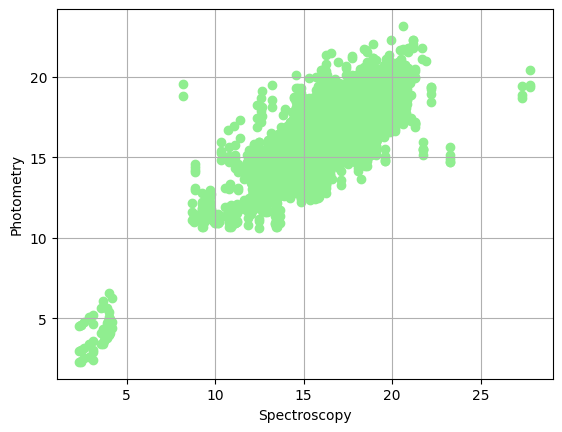

In [65]:
total_sp = np.array([])
total_lc = np.array([])
total_er = np.array([])

for name in training_set: 
    print('Working on ', name) 
    lc_filters, lc_set     = collect_lightcurves(name, lc_path)
    files, sp_set          = collect_spectra(name, sp_path)
    gp_set                 = gaussian_process(lc_filters, lc_set, files)
    wave_range             = wavelength_coverage(files, sp_set)
    spectral_filters       = filters_coverage(wave_range)
    tot_filters            = matched_bands(lc_filters, spectral_filters)
    sp, lc, er             = calibration(files, sp_set, gp_set, tot_filters) 

    total_sp = np.append(total_sp, abs(sp)) 
    total_lc = np.append(total_lc, abs(lc))  
    total_er = np.append(total_er, abs(er)) 

print('-----------------------------') 
print('We have a total of ', len(total_sp), 'points')
plt.scatter(total_sp, total_lc, color='lightgreen') 
plt.ylabel('Photometry') 
plt.xlabel('Spectroscopy') 
plt.grid() 

In [69]:
import math

output_path = "/home/andrea/Desktop/CASTOR2.0/Training_Set/calibration.dat"

with open(output_path, 'w') as f:
    for sp, lc, er in zip(total_sp, total_lc, total_er):
        if any(math.isnan(x) for x in (sp, lc, er)):  # Skip line if any value is NaN
            continue
        f.write(f"{sp} {lc} {er}\n")

print("Data saved to calibration.dat")


Data saved to calibration.dat


## Possiamo leggere da file più facilmente

In [70]:
total_lc_2 = np.array([]) 
total_sp_2 = np.array([])
total_er_2 = np.array([])
output_path = "/home/andrea/Desktop/CASTOR2.0/Training_Set/calibration.dat"

with open(output_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        total_sp_2 = np.append(total_sp_2, float(parts[0]))
        total_lc_2 = np.append(total_lc_2, float(parts[1]))
        total_er_2 = np.append(total_er_2, float(parts[2]))

In [71]:
from scipy.optimize  import curve_fit

def linear_fun(x, m, q):
    return m*x + q

par, cov = curve_fit(linear_fun, total_sp_2, total_lc_2, sigma=total_er_2)
m = par[0]
q = par[1]
variances = np.diag(cov)
errors    = np.sqrt(variances)
err_m = errors[0] 
err_q = errors[1] 
x_axis = np.linspace(np.min(total_sp_2), np.max(total_sp_2), 5000)
linear_fit = x_axis * m + q 
linear_fit_sigma = x_axis * err_m + err_q 

print('m =', round(m, 4), '+/-', round(err_m,4))
print('q =', round(q, 4), '+/-', round(err_q,4))

m = 0.9063 +/- 0.0026
q = 1.4732 +/- 0.0384


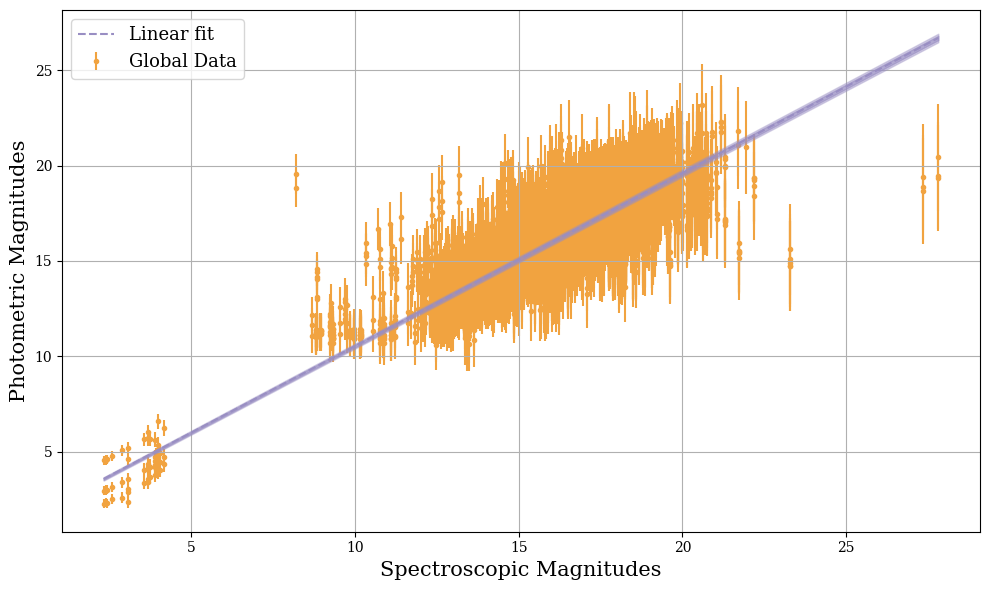

In [77]:
my_style = 'seaborn-v0_8-bright' 
with plt.style.context(my_style, after_reset=True):
    plt.figure(figsize=(10, 6))
    plt.rcParams["font.family"] = "DejaVu Serif"


    plt.errorbar(total_sp_2, total_lc_2, total_er_2, fmt='.', label='Global Data', color='#f1a340', zorder=1) 
    plt.plot(x_axis, linear_fit, '--',  label='Linear fit', color='#998ec3', zorder=2)
    plt.fill_between(x_axis, linear_fit + linear_fit_sigma, linear_fit - linear_fit_sigma, alpha=0.6 ,color='#998ec3', zorder=2)
    plt.fill_between(x_axis, linear_fit + 2*linear_fit_sigma, linear_fit - 2*linear_fit_sigma, alpha=0.4 ,color='#998ec3', zorder=2)

    plt.grid()
    plt.xlabel('Spectroscopic Magnitudes',  fontsize = 15)
    plt.ylabel('Photometric Magnitudes', fontsize = 15)

    #plt.gca().invert_yaxis()
    plt.legend(ncol=1, fontsize = 13)
    plt.tight_layout()
    fig_name = '/home/andrea/Desktop/CASTOR2.0/Training_Set/calibration.png'
    
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')
    pass

# Counting

In [128]:
import pandas as pd 

# excel_path      = "/home/andrea/Desktop/CASTORubin/Files/"
# training_path   = "/home/andrea/Desktop/CASTOR2.0/New_Training/"

training_set   = pd.read_excel(training_path + 'Training_Set.xlsx' )['Name'].tolist()
training_type  = pd.read_excel(training_path + 'Training_Set.xlsx' )['Type'].tolist()
training_red   = pd.read_excel(training_path + 'Training_Set.xlsx' )['Redshift'].tolist()
training_filt  = pd.read_excel(training_path + 'Training_Set.xlsx' )['Filters'].tolist()
training_sp    = pd.read_excel(training_path + 'Training_Set.xlsx' )['Spectra'].tolist()

lc_filters     = [] 
for filt_list in training_filt: 
    if 'u' in filt_list: lc_filters.append('u')
    if 'g' in filt_list: lc_filters.append('g')
    if 'r' in filt_list: lc_filters.append('r')
    if 'i' in filt_list: lc_filters.append('i')
    if 'z' in filt_list: lc_filters.append('z')

    if 'U' in filt_list: lc_filters.append('U')
    if 'B' in filt_list: lc_filters.append('B')
    if 'V' in filt_list: lc_filters.append('V')
    if 'R' in filt_list: lc_filters.append('R')
    if 'I' in filt_list: lc_filters.append('I')

    if 'J' in filt_list: lc_filters.append('J')
    if 'H' in filt_list: lc_filters.append('H')
    if 'K' in filt_list: lc_filters.append('K')
    if 'Ks' in filt_list: lc_filters.append('Ks')
    if 'Y' in filt_list: lc_filters.append('Y')

    if 'w1' in filt_list: lc_filters.append('w1')
    if 'w2' in filt_list: lc_filters.append('w2')
    if 'm2' in filt_list: lc_filters.append('m2')



In [129]:
print(f'There are : {len(training_set)} supernovae')

There are : 150 supernovae


In [130]:
desired_order  = ['w2', 'm2', 'w1', 'u', 'g', 'r', 'i', 'z', 'y', 
	           'U', 'B', 'V', 'R', 'I', 'Y',
	           'J', 'H', 'K', 'Ks']

new_filters = sorted(lc_filters, key=lambda x: desired_order.index(x))

In [131]:
def collect_lightcurves(name, path):
    lc_path   = path + 'data_lightcurves' + "/" + name + ".dat"
    lc_set    = defaultdict(list)
    band_dict = defaultdict(list)

    with open(lc_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            time  = float(parts[0])
            mag   = float(parts[1])
            emag  = float(parts[2])
            band  = parts[3]
            band_dict[band].append((time, mag, emag))

    for band, values in band_dict.items():
        lc_set[f'time_{band}'], lc_set[f'mag_{band}'], lc_set[f'emag_{band}'] = zip(*values)

    lc_filters         = list(band_dict.keys())

    return lc_filters, lc_set

In [132]:
max_epoch = [] 
for name in training_set: 

    spectra_path = "/home/andrea/Desktop/CASTOR2.0/Training_Set/data_spectra/" + name
    lc_filters, lc_set = collect_lightcurves(name, training_path)
    all_files    = os.listdir(spectra_path)
    
    files = [] 

    for single_file in all_files: 
        epoch     = float(single_file.split('_')[1].rsplit('.', 1)[0]) 
        files.append(epoch) 
    
    max_epoch.append(np.max(files))

In [133]:
class_counts

Counter({'Ib': 26,
         'Ic': 25,
         'II': 19,
         'IIP': 18,
         'IIb': 18,
         'IIn': 14,
         'Ic-BL': 9,
         'IIL': 7,
         'SLSN-I': 4,
         'Ibc': 3,
         'Ibn': 2,
         'Ic ': 2,
         'Ib/n': 1,
         'Ic-Ca-rich': 1,
         'Icn': 1})

/tmp/ipykernel_30412/1260112654.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(categories, rotation=45)
/tmp/ipykernel_30412/1260112654.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(categories, rotation=45)  # Rotate labels for readability


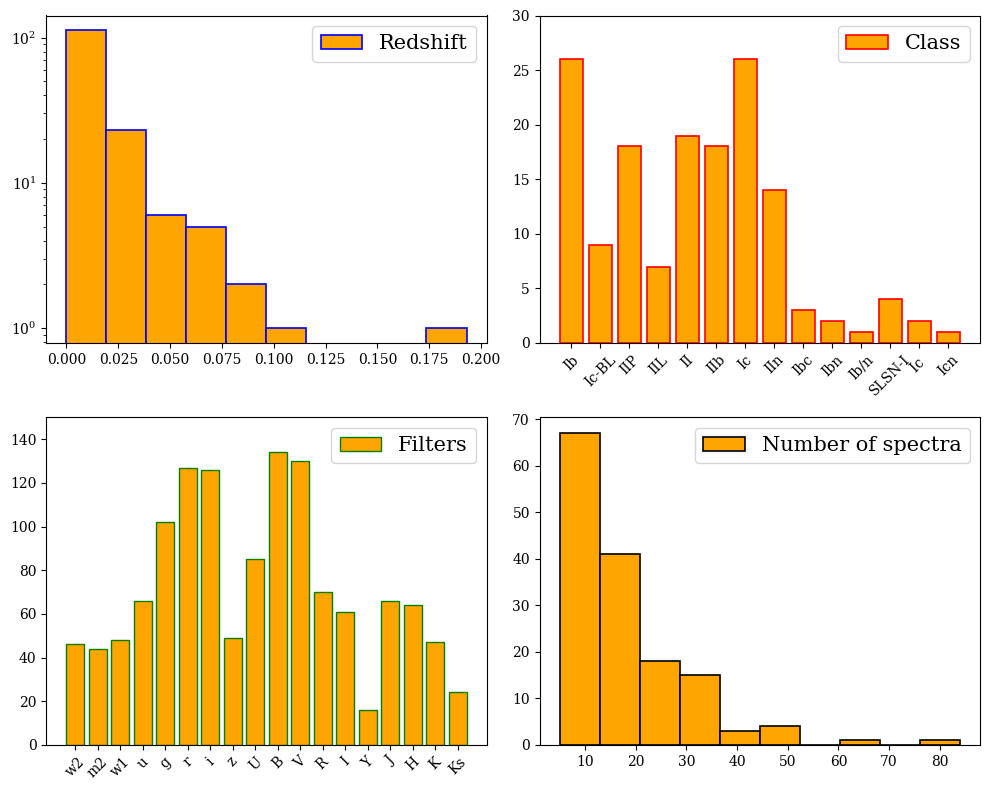

In [136]:
with plt.style.context(my_style, after_reset=True):

    plt.rcParams["font.family"] = "DejaVu Serif"
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Adjust figsize as needed

    # Plot histograms in each subplot
    axs[0, 0].hist(training_red, bins=10, color="orange", edgecolor='blue', linewidth=1.2)
    axs[0, 0].legend(['Redshift'], fontsize = 15)
    axs[0, 0].set_yscale('log')

    class_counts = Counter(training_type)
    categories = list(class_counts.keys())
    counts = list(class_counts.values())

    # Use a bar chart instead of a histogram
    axs[0, 1].bar(categories, counts, color="orange", edgecolor="red", linewidth=1.2)

    # Formatting
    axs[0, 1].legend(['Class'], fontsize=15)
    axs[0, 1].set_ylim(0, 30)
    axs[0, 1].set_xticklabels(categories, rotation=45)
    from collections import Counter

    # Count occurrences of each filter
    filter_counts = Counter(new_filters)
    categories = list(filter_counts.keys())
    counts = list(filter_counts.values())

    # Use a bar chart instead of a histogram
    axs[1, 0].bar(categories, counts, color="orange", edgecolor="green")

    # Formatting
    axs[1, 0].legend(['Filters'], fontsize=15)
    axs[1, 0].set_ylim(0, 150)
    axs[1, 0].set_xticklabels(categories, rotation=45)  # Rotate labels for readability


    axs[1, 1].hist(training_sp, bins=10, color="orange", edgecolor='black', linewidth=1.2)
    axs[1, 1].legend(['Number of spectra'], fontsize = 15)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('/home/andrea/Desktop/CASTOR2.0/Training_Set/training_set.png', dpi = 300)
    plt.show()


In [135]:
new_filters

['w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'w2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'w1',
 'u',
 'u',
 'u',
 'u',
 'u',
 'u'